In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-images-44c



# Image Dataset Balancing via Augmentation (Max 360 per Class)

This notebook takes an image dataset organized as:
```
dataset_root/
  class_a/
    img001.jpg
    ...
  class_b/
    img123.jpg
    ...
```
and **augments minority classes up to a maximum of 360 images per class** (configurable).

**What it does**  
- Reads class folders under `INPUT_DIR`  
- Counts images per class  
- Copies originals to `OUTPUT_DIR` (mirroring class structure)  
- Adds augmented images for classes with fewer than `MAX_PER_CLASS` images  
- Skips downsampling by default (you can turn it on with a flag)  
- Saves a report of class counts before/after

> Tip: Run each cell in order. Adjust the configuration first.


In [2]:

# --- Imports
import os
import random
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# Ensure non-interactive back-end in some environments
plt.switch_backend("agg")
print("Imports ready.")


Imports ready.


In [4]:
# --- Configuration
# Set this to your dataset root that contains one subfolder per class.
from pathlib import Path # Import Path
import random # Import random
import numpy as np # Import numpy

INPUT_DIR = Path("/root/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1")  # <- CHANGE THIS
# Output directory where the balanced dataset will be written.
OUTPUT_DIR = Path("/content/drive/My Drive/brain")  # <- CHANGE THIS - REPLACE WITH YOUR ACTUAL DRIVE PATH

# Maximum images per class after balancing
MAX_PER_CLASS = 365

# If True, classes with > MAX_PER_CLASS will be randomly downsampled to MAX_PER_CLASS in OUTPUT_DIR.
DOWNSAMPLE_IF_OVER = False

# Allowed file extensions (lowercase)
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Configured.")
print("INPUT_DIR:", INPUT_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("MAX_PER_CLASS:", MAX_PER_CLASS)
print("DOWNSAMPLE_IF_OVER:", DOWNSAMPLE_IF_OVER)

Configured.
INPUT_DIR: /root/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1
OUTPUT_DIR: /content/drive/My Drive/brain
MAX_PER_CLASS: 365
DOWNSAMPLE_IF_OVER: False


In [5]:

# --- Helpers: dataset scan and counting
def is_image_file(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in EXTS

def list_class_dirs(root: Path):
    return sorted([d for d in root.iterdir() if d.is_dir()])

def list_images_in_class(class_dir: Path):
    return sorted([p for p in class_dir.rglob("*") if is_image_file(p)])

def count_per_class(root: Path):
    rows = []
    for cdir in list_class_dirs(root):
        imgs = list_images_in_class(cdir)
        rows.append({"class": cdir.name, "count": len(imgs)})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

print("Helper functions ready.")


Helper functions ready.


In [6]:
# --- Image augmentation utilities
from PIL import Image # Import Image

def to_rgb(img: Image.Image) -> Image.Image:
    if img.mode != "RGB":
        return img.convert("RGB")
    return img

def random_flip(img: Image.Image) -> Image.Image:
    if random.random() < 0.5:
        img = ImageOps.mirror(img)  # horizontal flip
    if random.random() < 0.15:
        img = ImageOps.flip(img)    # vertical flip (less frequent)
    return img

def random_rotate(img: Image.Image, max_deg=25) -> Image.Image:
    angle = random.uniform(-max_deg, max_deg)
    return img.rotate(angle, resample=Image.BICUBIC, expand=True)

def random_brightness(img: Image.Image, low=0.7, high=1.3) -> Image.Image:
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(random.uniform(low, high))

def random_contrast(img: Image.Image, low=0.7, high=1.3) -> Image.Image:
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(random.uniform(low, high))

def random_color(img: Image.Image, low=0.8, high=1.2) -> Image.Image:
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(random.uniform(low, high))

def random_sharpness(img: Image.Image, low=0.7, high=1.5) -> Image.Image:
    enhancer = ImageEnhance.Sharpness(img)
    return enhancer.enhance(random.uniform(low, high))

def random_blur(img: Image.Image, prob=0.2):
    if random.random() < prob:
        radius = random.uniform(0.5, 1.5)
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img

def random_noise(img: Image.Image, sigma_range=(5, 20)) -> Image.Image:
    # Add gaussian noise
    arr = np.array(img).astype(np.float32)
    sigma = random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, arr.shape).astype(np.float32)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def random_resize_pad(img: Image.Image, target_size=(256, 256)) -> Image.Image:
    # Random scale, then center-pad/crop to target
    w, h = img.size
    scale = random.uniform(0.9, 1.1)
    new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
    img = img.resize((new_w, new_h), resample=Image.BICUBIC)
    # Paste onto canvas
    canvas = Image.new("RGB", target_size, (0, 0, 0))
    x = max(0, (target_size[0] - new_w)//2)
    y = max(0, (target_size[1] - new_h)//2)
    canvas.paste(img, (x, y))
    return canvas

def random_crop(img: Image.Image, min_ratio=0.8, target_size=(256, 256)) -> Image.Image:
    w, h = img.size
    crop_ratio = random.uniform(min_ratio, 1.0)
    cw, ch = int(w*crop_ratio), int(h*crop_ratio)
    if cw < 1 or ch < 1:
        return img.resize(target_size, Image.BICUBIC)
    left = random.randint(0, max(0, w - cw))
    top = random.randint(0, max(0, h - ch))
    img = img.crop((left, top, left+cw, top+ch))
    return img.resize(target_size, Image.BICUBIC)

def augment_once(img: Image.Image) -> Image.Image:
    # Pipeline: convert -> random geometric/color ops -> resize/crop to standard size
    img = to_rgb(img)
    # Randomly choose between two spatial paths
    if random.random() < 0.5:
        img = random_rotate(img, max_deg=20)
        img = random_resize_pad(img, target_size=(256, 256))
    else:
        img = random_crop(img, min_ratio=0.85, target_size=(256, 256))
    # Photometric changes
    if random.random() < 0.9: img = random_brightness(img)
    if random.random() < 0.9: img = random_contrast(img)
    if random.random() < 0.6: img = random_color(img)
    if random.random() < 0.5: img = random_sharpness(img)
    img = random_flip(img)
    img = random_blur(img, prob=0.2)
    if random.random() < 0.5:
        img = random_noise(img, sigma_range=(2, 12))
    return img

print("Augmentation functions ready.")

Augmentation functions ready.


In [7]:
# --- Baseline class counts
import pandas as pd # Import pandas
import matplotlib.pyplot as plt # Import matplotlib.pyplot

assert INPUT_DIR.exists(), f"INPUT_DIR does not exist: {INPUT_DIR}"
base_counts_df = count_per_class(INPUT_DIR)
display(base_counts_df)
print("Total classes:", len(base_counts_df))
print("Total images:", base_counts_df["count"].sum())

# Optional: bar plot of baseline distribution
plt.figure(figsize=(10, 5))
plt.bar(base_counts_df["class"], base_counts_df["count"])
plt.title("Class distribution BEFORE balancing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

,class,count
0,Astrocitoma T1,176
1,Astrocitoma T1C+,233
2,Astrocitoma T2,171
3,Carcinoma T1,66
4,Carcinoma T1C+,112
5,Carcinoma T2,73
6,Ependimoma T1,45
7,Ependimoma T1C+,48
8,Ependimoma T2,57
9,Ganglioglioma T1,20


Total classes: 44
Total images: 4479


In [8]:
# --- Balance by augmentation to MAX_PER_CLASS
import shutil # Import shutil
from PIL import Image, ImageOps, ImageEnhance, ImageFilter # Import Image, ImageOps, ImageEnhance, ImageFilter
import numpy as np # Import numpy
from pathlib import Path # Import Path

def copy_originals_and_balance():
    class_dirs = list_class_dirs(INPUT_DIR)
    for cdir in class_dirs:
        cname = cdir.name
        out_cdir = OUTPUT_DIR / cname
        out_cdir.mkdir(parents=True, exist_ok=True)

        images = list_images_in_class(cdir)
        n_orig = len(images)

        # Optionally downsample if over
        if DOWNSAMPLE_IF_OVER and n_orig > MAX_PER_CLASS:
            chosen = np.random.choice(images, size=MAX_PER_CLASS, replace=False)
            chosen = list(map(Path, map(str, chosen)))  # ensure Paths
            # Clear any existing files in out_cdir
            for f in out_cdir.glob("*"):
                if f.is_file():
                    f.unlink()
            # Copy downsampled originals
            for p in chosen:
                shutil.copy2(p, out_cdir / p.name)
            print(f"[{cname}] Downsampled {n_orig} -> {MAX_PER_CLASS}")
            continue
        else:
            # Copy all originals
            for p in images:
                shutil.copy2(p, out_cdir / p.name)

        # Augment if under
        if n_orig < MAX_PER_CLASS:
            need = MAX_PER_CLASS - n_orig
            print(f"[{cname}] Augmenting {need} images (orig={n_orig})")
            # Cycle through originals and create augmented versions until we hit target
            idx = 0
            used = 0
            while used < need:
                src = images[idx % n_orig]
                with Image.open(src) as im:
                    aug = augment_once(im)
                    out_name = f"{src.stem}_aug_{used:04d}.jpg"
                    aug.save(out_cdir / out_name, quality=95)
                idx += 1
                used += 1
        else:
            print(f"[{cname}] Already >= MAX_PER_CLASS (orig={n_orig}), copied originals only.")

copy_originals_and_balance()
print("Balancing complete. Output at:", OUTPUT_DIR)

[Astrocitoma T1] Augmenting 189 images (orig=176)
[Astrocitoma T1C+] Augmenting 132 images (orig=233)
[Astrocitoma T2] Augmenting 194 images (orig=171)
[Carcinoma T1] Augmenting 299 images (orig=66)
[Carcinoma T1C+] Augmenting 253 images (orig=112)
[Carcinoma T2] Augmenting 292 images (orig=73)
[Ependimoma T1] Augmenting 320 images (orig=45)
[Ependimoma T1C+] Augmenting 317 images (orig=48)
[Ependimoma T2] Augmenting 308 images (orig=57)
[Ganglioglioma T1] Augmenting 345 images (orig=20)
[Ganglioglioma T1C+] Augmenting 347 images (orig=18)
[Ganglioglioma T2] Augmenting 342 images (orig=23)
[Germinoma T1] Augmenting 338 images (orig=27)
[Germinoma T1C+] Augmenting 325 images (orig=40)
[Germinoma T2] Augmenting 332 images (orig=33)
[Glioblastoma T1] Augmenting 310 images (orig=55)
[Glioblastoma T1C+] Augmenting 271 images (orig=94)
[Glioblastoma T2] Augmenting 310 images (orig=55)
[Granuloma T1] Augmenting 335 images (orig=30)
[Granuloma T1C+] Augmenting 334 images (orig=31)
[Granuloma T

,class,count
0,Astrocitoma T1,365
1,Astrocitoma T1C+,365
2,Astrocitoma T2,365
3,Carcinoma T1,365
4,Carcinoma T1C+,365
5,Carcinoma T2,365
6,Ependimoma T1,365
7,Ependimoma T1C+,365
8,Ependimoma T2,365
9,Ganglioglioma T1,365


Total classes: 44
Total images: 16064
Saved reports to: /content/sample_data/_reports


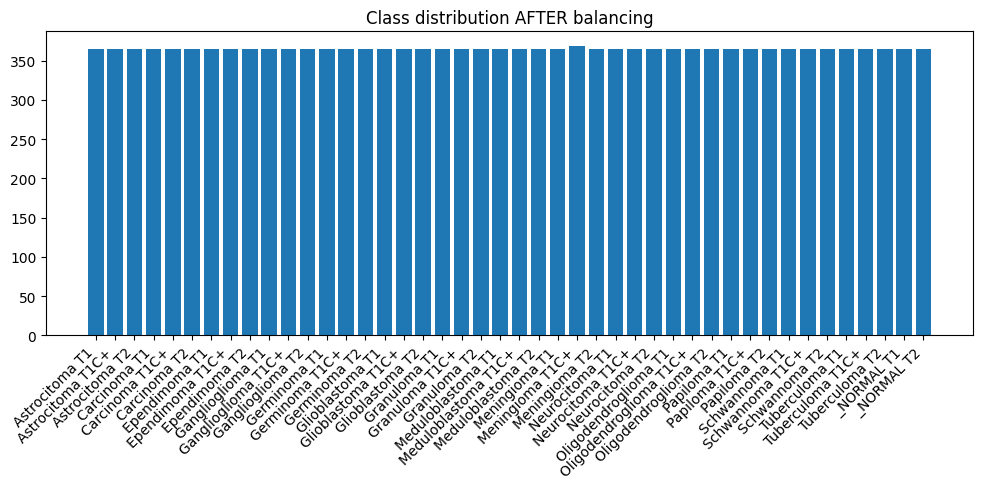

In [15]:

# --- Report AFTER balancing
after_counts_df = count_per_class(OUTPUT_DIR)
display(after_counts_df)
print("Total classes:", len(after_counts_df))
print("Total images:", after_counts_df["count"].sum())

# Save CSV reports
report_dir = OUTPUT_DIR / "_reports"
report_dir.mkdir(parents=True, exist_ok=True)
base_counts_df.to_csv(report_dir / "before_counts.csv", index=False)
after_counts_df.to_csv(report_dir / "after_counts.csv", index=False)
print("Saved reports to:", report_dir)

# Bar plot AFTER
plt.figure(figsize=(10, 5))
plt.bar(after_counts_df["class"], after_counts_df["count"])
plt.title("Class distribution AFTER balancing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:

# --- Quick sanity check: preview a few augmented samples from one class (optional)
# Change 'some_class_name' to a real class name present in your dataset.
some_class_name = None  # e.g., "cats"
if some_class_name is not None:
    from IPython.display import display
    cpath = OUTPUT_DIR / some_class_name
    imgs = [p for p in cpath.glob("*.jpg")]
    for p in imgs[:5]:
        print(p.name)
        display(Image.open(p))
else:
    print("Set 'some_class_name' to preview images.")


Set 'some_class_name' to preview images.



## Notes & Tips

- If you need stronger augmentations (e.g., perspective transforms), consider libraries like **Albumentations** or **imgaug** in your own environment.
- Keep validation and test sets **unaugmented** to avoid data leakage.
- You can change the target size in `random_resize_pad` / `random_crop` to match your model input (e.g., 224×224 for many CNNs).
- If you need to **preserve filenames** and write augmented images to a separate folder (e.g., `aug/`), adapt the save logic accordingly.
- Set `DOWNSAMPLE_IF_OVER = True` if you want to cap all classes at exactly `MAX_PER_CLASS`.
